In [1]:
import model
import data
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt

To avoid verbose warning messages... 

In [2]:
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)

Load MNIST dataset via a Dataset object:

In [3]:
dataset = data.Dataset(batch_size=128)

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz
55000


Training parameters:

In [4]:
learning_rate=0.001
num_steps = 5000
batch_size = 128

Model parameters:

In [5]:
temperature = 1
dropout = 0.75

## Main Model Training

- ### Teacher Model

Output directory for model checkpoint:

In [6]:
checkpoint_dir="teachercpt_t1_test"
log_dir=checkpoint_dir + "\logs"

Model definition:

In [12]:
teacher_model = model.BigModel(num_steps=num_steps, 
                               batch_size=batch_size,
                               learning_rate=learning_rate,
                               temperature=temperature,
                               dropoutprob=dropout,
                               checkpoint_dir=checkpoint_dir,
                               log_dir=log_dir,
                               model_type="teacher");

Training:

At each step, the validation accuracy is computed and, if maximal, a model checkpoint is created. This is, in a way, analogous to **early stopping**.

In [13]:
teacher_model.start_session()

In [8]:
teacher_model.train(dataset)

Starting Training
Model Checkpointed to teachercpt_t1_test\bigmodel.ckpt 
Step 1, Validation Loss= 64815.7266, Validation Accuracy= 0.057
Model Checkpointed to teachercpt_t1_test\bigmodel.ckpt 
Step 100, Validation Loss= 2279.0669, Validation Accuracy= 0.867
Model Checkpointed to teachercpt_t1_test\bigmodel.ckpt 
Step 200, Validation Loss= 1206.1360, Validation Accuracy= 0.923
Model Checkpointed to teachercpt_t1_test\bigmodel.ckpt 
Step 300, Validation Loss= 824.3567, Validation Accuracy= 0.941
Model Checkpointed to teachercpt_t1_test\bigmodel.ckpt 
Step 400, Validation Loss= 651.7480, Validation Accuracy= 0.947
Model Checkpointed to teachercpt_t1_test\bigmodel.ckpt 
Step 500, Validation Loss= 522.9631, Validation Accuracy= 0.954
Model Checkpointed to teachercpt_t1_test\bigmodel.ckpt 
Step 600, Validation Loss= 403.8199, Validation Accuracy= 0.959
Model Checkpointed to teachercpt_t1_test\bigmodel.ckpt 
Step 700, Validation Loss= 341.4933, Validation Accuracy= 0.963
Model Checkpointed t

Test the **teacher model** (compute its accuracy againts the testing dataset) on the best model based on the validation set, this is, the *checkpointed model*. 

In [14]:
# Load the best model from created checkpoint
teacher_model.load_model_from_file(checkpoint_dir)
# Test the model against the testing set
teacher_model.run_inference(dataset)

Reading model parameters from teachercpt_t1_test\bigmodel.ckpt
Testing Accuracy: 0.983355


In [10]:
# Close current tf session
teacher_model.close_session()

In [11]:
tf.reset_default_graph()

- ### Simple Student Model
Simple, as in, trained with the same data and parameters as the teacher model. 

Output directory for model checkpoint:

In [6]:
checkpoint_dir="sstudentcpt_t1"
log_dir=checkpoint_dir + "\logs"

Model definition:

In [7]:
student_model = model.SmallModel(num_steps=num_steps, 
                                 batch_size=batch_size,
                                 learning_rate=learning_rate,
                                 temperature=temperature,
                                 dropoutprob=0,
                                 checkpoint_dir=checkpoint_dir,
                                 log_dir=log_dir,
                                 model_type="student");

Training:

At each step, the validation accuracy is computed and, if maximal, a model checkpoint is created. This is, in a way, analogous to **early stopping**.

In [8]:
student_model.start_session()
student_model.train(dataset)

Starting Training
Model Checkpointed to sstudentcpt_t1\smallmodel 
Step 1, Validation Loss= 14.2813, Validation Accuracy= 0.049
Model Checkpointed to sstudentcpt_t1\smallmodel 
Step 100, Validation Loss= 8.7166, Validation Accuracy= 0.150
Model Checkpointed to sstudentcpt_t1\smallmodel 
Step 200, Validation Loss= 5.8832, Validation Accuracy= 0.269
Model Checkpointed to sstudentcpt_t1\smallmodel 
Step 300, Validation Loss= 4.2642, Validation Accuracy= 0.387
Model Checkpointed to sstudentcpt_t1\smallmodel 
Step 400, Validation Loss= 3.2869, Validation Accuracy= 0.477
Model Checkpointed to sstudentcpt_t1\smallmodel 
Step 500, Validation Loss= 2.6678, Validation Accuracy= 0.550
Model Checkpointed to sstudentcpt_t1\smallmodel 
Step 600, Validation Loss= 2.2593, Validation Accuracy= 0.598
Model Checkpointed to sstudentcpt_t1\smallmodel 
Step 700, Validation Loss= 1.9642, Validation Accuracy= 0.641
Model Checkpointed to sstudentcpt_t1\smallmodel 
Step 800, Validation Loss= 1.7413, Validation 

Test the **student model** (compute its accuracy againts the testing dataset) on the best model based on the validation set, this is, the *checkpointed model*. 

In [9]:
# Load the best model from created checkpoint
student_model.load_model_from_file(checkpoint_dir)
# Test the model against the testing set
student_model.run_inference(dataset)

Reading model parameters from sstudentcpt_t1\smallmodel
Testing Accuracy: 0.882048


In [10]:
# Close current tf session
student_model.close_session()

- ### Distilled Student Model
Training data consists of the **logits** from the Teacher Model predictions of the standard training set.

Pretrained **teacher model** loading:

In [6]:
checkpoint_dir = "teachercpt_t1"
log_dir=checkpoint_dir + "\logs"

In [7]:
# Model definition
teacher_model = model.BigModel(num_steps=num_steps, 
                               batch_size=batch_size,
                               learning_rate=learning_rate,
                               temperature=temperature,
                               dropoutprob=dropout,
                               checkpoint_dir=checkpoint_dir,
                               log_dir=log_dir,
                               model_type="teacher");
# Start tf session
teacher_model.start_session()

In [8]:
# Load best model from teacher checkpoint
teacher_model.load_model_from_file(checkpoint_dir)

Reading model parameters from teachercpt_t1\bigmodel.ckpt


Verify **teacher** model state before training **student**:

In [9]:
# Test the model against the testing set
teacher_model.run_inference(dataset)

Testing Accuracy: 0.978456


Testing for a good temperature (one that better softens the probabilities):

In [10]:
test_images, test_labels = dataset.get_test_data()

In [38]:
res1 = teacher_model.predict(test_images[:10],5000)
res2 = teacher_model.predict(test_images[:10],6000)
res3 = teacher_model.predict(test_images[:10],7000)
res4 = teacher_model.predict(test_images[:10],8000)
res5 = teacher_model.predict(test_images[:10],9000)
res6 = teacher_model.predict(test_images[:10],10000)

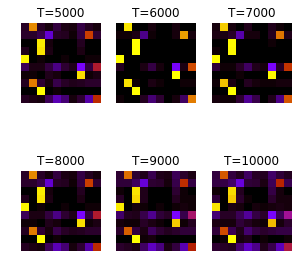

In [39]:
f = plt.figure(figsize=(10,10))
f.add_subplot(1,6, 1)
plt.imshow(res4, cmap='gnuplot', interpolation='nearest')
title_obj = plt.title('T=8000')
plt.axis('off')
f.add_subplot(1,6, 2)
plt.imshow(res5, cmap='gnuplot', interpolation='nearest')
title_obj = plt.title('T=9000')
plt.axis('off')
f.add_subplot(1,6, 3)
plt.imshow(res6, cmap='gnuplot', interpolation='nearest')
title_obj = plt.title('T=10000')
plt.axis('off')
f.add_subplot(2,6, 1)
plt.imshow(res4, cmap='gnuplot', interpolation='nearest')
title_obj = plt.title('T=5000')
plt.axis('off')
f.add_subplot(2,6, 2)
plt.imshow(res1, cmap='gnuplot', interpolation='nearest')
title_obj = plt.title('T=6000')
plt.axis('off')
f.add_subplot(2,6, 3)
plt.imshow(res2, cmap='gnuplot', interpolation='nearest')
title_obj = plt.title('T=7000')
plt.axis('off')
plt.show()

Output directory for distilled student model checkpoint:

In [40]:
checkpoint_dir="dstudentcpt_t8000"
log_dir=checkpoint_dir + "\logs"

Student model definition:

In [41]:
student_model = model.SmallModel(num_steps=num_steps, 
                                 batch_size=batch_size,
                                 learning_rate=0.001,
                                 temperature=8000,
                                 dropoutprob=0,
                                 checkpoint_dir=checkpoint_dir,
                                 log_dir=log_dir,
                                 model_type="student");

Training:

At each step, the validation accuracy is computed and, if maximal, a model checkpoint is created. This is, in a way, analogous to **early stopping**.

In [42]:
student_model.start_session()
student_model.train(dataset, teacher_model)

Starting Training
Model Checkpointed to dstudentcpt_t8000\smallmodel 
Step 1, Validation Loss= 2617.7761, Validation Accuracy= 0.142
Model Checkpointed to dstudentcpt_t8000\smallmodel 
Step 100, Validation Loss= 896.4868, Validation Accuracy= 0.744
Model Checkpointed to dstudentcpt_t8000\smallmodel 
Step 200, Validation Loss= 799.4957, Validation Accuracy= 0.831
Model Checkpointed to dstudentcpt_t8000\smallmodel 
Step 300, Validation Loss= 757.0855, Validation Accuracy= 0.866
Model Checkpointed to dstudentcpt_t8000\smallmodel 
Step 400, Validation Loss= 734.1108, Validation Accuracy= 0.883
Model Checkpointed to dstudentcpt_t8000\smallmodel 
Step 500, Validation Loss= 729.3098, Validation Accuracy= 0.891
Model Checkpointed to dstudentcpt_t8000\smallmodel 
Step 600, Validation Loss= 707.3793, Validation Accuracy= 0.894
Model Checkpointed to dstudentcpt_t8000\smallmodel 
Step 700, Validation Loss= 689.8049, Validation Accuracy= 0.897
Model Checkpointed to dstudentcpt_t8000\smallmodel 
Ste

Test the **distilled student model** (compute its accuracy againts the testing dataset) on the best model based on the validation set, this is, the *checkpointed model*. 

In [43]:
# Load the best model from created checkpoint
student_model.load_model_from_file(checkpoint_dir)
# Test the model against the testing set
student_model.run_inference(dataset)

Reading model parameters from dstudentcpt_t8000\smallmodel
Testing Accuracy: 0.909856


In [ ]:
# Close current tf sessions
teacher_model.close_session()
student_model.close_session()

## Logits from file

In [12]:
def unpickle(file):    
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [13]:
logits_train = unpickle('logits_dir/resnet164_logits_train.txt')

In [14]:
logits_train

[]

## Experiments

- ### 1. Learn from Probabilities
Take a class out from the training set for the Distilled Model, and later test the accuracy for that class. 

In [6]:
# MNIST dataset with class 3 excluded from training
dataset_ex = data.DatasetExclude(batch_size=128, exclude_class=[3])

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz
55000


Pretrained **teacher model** loading:

In [7]:
checkpoint_dir = "teachercpt_t1"
log_dir=checkpoint_dir + "\logs"

In [8]:
# Model definition
teacher_model = model.BigModel(num_steps=num_steps, 
                               batch_size=batch_size,
                               learning_rate=learning_rate,
                               temperature=temperature,
                               dropoutprob=dropout,
                               checkpoint_dir=checkpoint_dir,
                               log_dir=log_dir,
                               model_type="teacher");
# Start tf session
teacher_model.start_session()

In [9]:
# Load best model from teacher checkpoint
teacher_model.load_model_from_file(checkpoint_dir)

Reading model parameters from teachercpt_t1\bigmodel.ckpt


Verify **teacher** model state before training **student**:

In [10]:
# Test the model against the testing set
teacher_model.run_inference(dataset)

Testing Accuracy: 0.978329


Output directory for distilled student model checkpoint:

In [11]:
checkpoint_dir="ex1_dstudentcpt_t8000_gd"
log_dir=checkpoint_dir + "\logs"

Student model definition:

In [12]:
student_model = model.SmallModel(num_steps=5000, 
                                 batch_size=batch_size,
                                 learning_rate=0.001,
                                 temperature=8000,
                                 dropoutprob=0,
                                 checkpoint_dir=checkpoint_dir,
                                 log_dir=log_dir,
                                 model_type="student");

Training:

At each step, the validation accuracy is computed and, if maximal, a model checkpoint is created. This is, in a way, analogous to **early stopping**.

In [13]:
student_model.start_session()

In [14]:
student_model.train(dataset_ex, teacher_model)

Starting Training
Model Checkpointed to ex1_dstudentcpt_t8000_gd\smallmodel 
Step 1, Validation Loss= 3657.5715, Validation Accuracy= 0.108
Model Checkpointed to ex1_dstudentcpt_t8000_gd\smallmodel 
Step 100, Validation Loss= 2197.6946, Validation Accuracy= 0.684
Model Checkpointed to ex1_dstudentcpt_t8000_gd\smallmodel 
Step 200, Validation Loss= 2170.9675, Validation Accuracy= 0.760
Model Checkpointed to ex1_dstudentcpt_t8000_gd\smallmodel 
Step 300, Validation Loss= 2080.8770, Validation Accuracy= 0.784
Model Checkpointed to ex1_dstudentcpt_t8000_gd\smallmodel 
Step 400, Validation Loss= 1974.6926, Validation Accuracy= 0.796
Model Checkpointed to ex1_dstudentcpt_t8000_gd\smallmodel 
Step 500, Validation Loss= 1905.7006, Validation Accuracy= 0.801
Model Checkpointed to ex1_dstudentcpt_t8000_gd\smallmodel 
Step 600, Validation Loss= 1834.5573, Validation Accuracy= 0.807
Model Checkpointed to ex1_dstudentcpt_t8000_gd\smallmodel 
Step 700, Validation Loss= 1797.7828, Validation Accuracy

Test the **distilled student model** (compute its accuracy againts the testing dataset) on the best model based on the validation set, this is, the *checkpointed model*. 

In [15]:
# Load the best model from created checkpoint
student_model.load_model_from_file(checkpoint_dir)
# Test the model against the testing set
student_model.run_inference(dataset)

Reading model parameters from ex1_dstudentcpt_t8000_gd\smallmodel
Testing Accuracy: 0.834808


In [16]:
# Test the model againts a testing set containing only the initially excluded class
student_model.run_inference_ex(dataset_ex)

Testing Accuracy: 0.101980194


In [12]:
# Close current tf sessions
teacher_model.close_session()
student_model.close_session()

NameError: name 'student_model' is not defined

- ### 1.2 Learn from Probabilities (only 7s and 8s)
Take multiple classes out from the training set for the Distilled Model, and later test the accuracy for those classes. 

In [6]:
# MNIST dataset with class 3 excluded from training
dataset_ex = data.DatasetExclude(batch_size=128, exclude_class=[0,1,2,3,4,5,6,9])

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz
55000


Pretrained **teacher model** loading:

In [7]:
checkpoint_dir = "teachercpt_t1"
log_dir=checkpoint_dir + "\logs"

In [8]:
# Model definition
teacher_model = model.BigModel(num_steps=num_steps, 
                               batch_size=batch_size,
                               learning_rate=learning_rate,
                               temperature=temperature,
                               dropoutprob=dropout,
                               checkpoint_dir=checkpoint_dir,
                               log_dir=log_dir,
                               model_type="teacher");
# Start tf session
teacher_model.start_session()

In [9]:
# Load best model from teacher checkpoint
teacher_model.load_model_from_file(checkpoint_dir)

Reading model parameters from teachercpt_t1\bigmodel.ckpt


Verify **teacher** model state before training **student**:

In [10]:
# Test the model against the testing set
teacher_model.run_inference(dataset)

Testing Accuracy: 0.978529


Output directory for distilled student model checkpoint:

In [11]:
checkpoint_dir="ex1.2_dstudentcpt_t8000"
log_dir=checkpoint_dir + "\logs"

Student model definition:

In [12]:
student_model = model.SmallModel(num_steps=5000, 
                                 batch_size=batch_size,
                                 learning_rate=0.001,
                                 temperature=8000,
                                 dropoutprob=0,
                                 checkpoint_dir=checkpoint_dir,
                                 log_dir=log_dir,
                                 model_type="student");

Training:

At each step, the validation accuracy is computed and, if maximal, a model checkpoint is created. This is, in a way, analogous to **early stopping**.

In [13]:
student_model.start_session()

In [14]:
student_model.train(dataset_ex, teacher_model)

Starting Training
Model Checkpointed to ex1.2_dstudentcpt_t8000\smallmodel 
Step 1, Validation Loss= 3158.3208, Validation Accuracy= 0.072
Model Checkpointed to ex1.2_dstudentcpt_t8000\smallmodel 
Step 100, Validation Loss= 12331.0996, Validation Accuracy= 0.197
Model Checkpointed to ex1.2_dstudentcpt_t8000\smallmodel 
Step 200, Validation Loss= 9836.1826, Validation Accuracy= 0.202
Model Checkpointed to ex1.2_dstudentcpt_t8000\smallmodel 
Step 300, Validation Loss= 8621.6064, Validation Accuracy= 0.217
Model Checkpointed to ex1.2_dstudentcpt_t8000\smallmodel 
Step 400, Validation Loss= 7561.4312, Validation Accuracy= 0.238
Model Checkpointed to ex1.2_dstudentcpt_t8000\smallmodel 
Step 500, Validation Loss= 7168.3433, Validation Accuracy= 0.255
Model Checkpointed to ex1.2_dstudentcpt_t8000\smallmodel 
Step 600, Validation Loss= 6517.7607, Validation Accuracy= 0.286
Model Checkpointed to ex1.2_dstudentcpt_t8000\smallmodel 
Step 700, Validation Loss= 6383.0327, Validation Accuracy= 0.297

Test the **distilled student model** (compute its accuracy againts the testing dataset) on the best model based on the validation set, this is, the *checkpointed model*. 

In [15]:
# Load the best model from created checkpoint
student_model.load_model_from_file(checkpoint_dir)
# Test the model against the testing set
student_model.run_inference(dataset)

Reading model parameters from ex1.2_dstudentcpt_t8000\smallmodel
Testing Accuracy: 0.405558


In [16]:
# Test the model againts a testing set containing only the initially excluded class
student_model.run_inference_ex(dataset_ex)

Testing Accuracy: 0.17301923


In [17]:
# Close current tf sessions
teacher_model.close_session()
student_model.close_session()

- ### 2. Train distilled model with a transfer set

### Tests

In [12]:
only3Data = dataset_ex.get_test_data_ex()

In [13]:
test_images_ex, test_labels_ex = dataset_ex.get_test_data_ex()

In [14]:
res3 = student_model.predict(test_images_ex)
res3

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

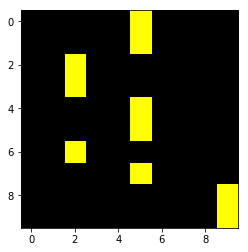

In [15]:
plt.imshow(res3[10:20], cmap='gnuplot', interpolation='nearest')
plt.show()

In [19]:
labels = [np.argmax(x) for x in res3];

In [22]:
len([x for x in labels if x != 3])

894

Softness

In [15]:
test_images, test_labels = dataset.get_test_data()

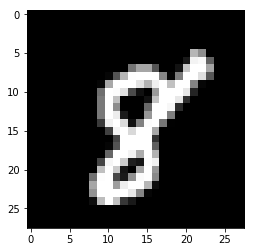

In [19]:
plt.imshow(test_images[0].reshape((28,28)),cmap='gray')

In [23]:
res = teacher_model.predict(test_images[:10],10000)
res

array([[0.04089586, 0.04092737, 0.04962095, 0.04136375, 0.08206078,
        0.1001733 , 0.01421009, 0.06718715, 0.4887782 , 0.07478254],
       [0.01569097, 0.01682891, 0.06861551, 0.01637091, 0.5929583 ,
        0.02770383, 0.07067044, 0.06026499, 0.05569917, 0.07519696],
       [0.05117282, 0.5726818 , 0.07585127, 0.02457857, 0.04660194,
        0.01990474, 0.09778718, 0.02279269, 0.06157516, 0.02705398],
       [0.05328405, 0.361957  , 0.08642762, 0.04911255, 0.07693649,
        0.05879812, 0.02697551, 0.06795635, 0.13335422, 0.08519803],
       [0.04993464, 0.44455495, 0.05293648, 0.03638805, 0.08600125,
        0.04866466, 0.06455316, 0.08096633, 0.09197461, 0.04402595],
       [0.01002602, 0.02438503, 0.8622043 , 0.03399917, 0.0053475 ,
        0.00176408, 0.01026637, 0.01981735, 0.0239258 , 0.00826431],
       [0.02450964, 0.01329821, 0.01889596, 0.04763559, 0.04371953,
        0.02689198, 0.02553801, 0.02993845, 0.06133112, 0.7082415 ],
       [0.07719847, 0.36419636, 0.0742538

In [18]:
res = teacher_model.predict_logits(test_images[:3],1)
res

array([[ -3977.8525,  -3970.1506,  -2044.0066,  -3864.0913,   2986.4612,
          4980.877 , -14548.611 ,    986.6786,  20830.955 ,   2057.7039],
       [-12461.821 , -11761.687 ,   2292.5142, -12037.602 ,  23858.572 ,
         -6776.9575,   2587.6118,    994.8457,    206.9818,   3208.4446],
       [ -1510.3839,  22640.832 ,   2425.2754,  -8843.718 ,  -2446.0474,
        -10952.892 ,   4965.4717,  -9598.065 ,    340.1169,  -7884.1284]],
      dtype=float32)

In [14]:
print(teacher_model.sess.run(tf.nn.softmax(res)))

[[2.7916129e-03 4.2871856e-03 1.3053397e-03 6.1616125e-03 8.8885218e-01
  4.8505040e-03 4.9903276e-03 2.8985638e-02 6.0165520e-03 5.1758908e-02]
 [5.3022010e-03 1.4904720e-03 3.9358661e-02 8.6619437e-01 4.1309278e-03
  4.1009989e-02 2.3818229e-05 3.0705535e-03 6.6504464e-03 3.2768480e-02]
 [1.7348994e-02 9.1900963e-01 1.3496629e-02 1.1434292e-02 5.0344146e-03
  7.2072139e-03 4.0047048e-03 9.3770269e-03 9.6641490e-03 3.4228223e-03]]


In [21]:
student_model.predict(test_images[:3],5000)

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [18]:
test_labels[:3]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])

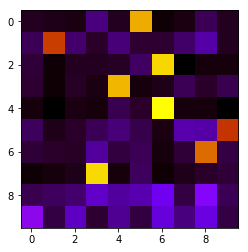

In [25]:
plt.imshow(res, cmap='gnuplot', interpolation='nearest')
plt.show()

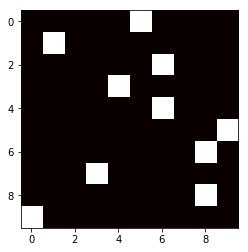

In [22]:
plt.imshow(test_labels[:10], cmap='hot', interpolation='nearest')
plt.show()

In [23]:
test_images.shape

(10000, 784)

From Nga's mnist:

In [ ]:
# Data used in ResNet164
(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_mnist()